In [21]:
import cv2
import pandas as pd
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

import torch
import random
import os

In [9]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [11]:
df = pd.read_csv('/home/heye0507/wheat_detection/data/train.csv')

bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [90]:
def get_train_transforms():
    return A.Compose(
        [
#             A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
#             A.OneOf([
#                 A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
#                                      val_shift_limit=0.2, p=0.9),
#                 A.RandomBrightnessContrast(brightness_limit=0.2, 
#                                            contrast_limit=0.2, p=0.9),
#             ],p=0.9),
#             A.ToGray(p=0.01),
#             A.HorizontalFlip(p=0.5),
#             A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [91]:
aug = get_train_transforms()

In [24]:
test_img_path = '/home/heye0507/wheat_detection/data/train/b6ab77fd7.jpg'

In [25]:
image = cv2.imread(f'{test_img_path}',cv2.IMREAD_COLOR)

In [27]:
image.shape

(1024, 1024, 3)

In [28]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

In [30]:
image /= 255.0

In [31]:
records = df[df['image_id'] == 'b6ab77fd7']

In [46]:
boxes = records[['x','y','w','h']].values

In [47]:
boxes[:,2] = boxes[:,0] + boxes[:,2]
boxes[:,3] = boxes[:,1] + boxes[:,3]

In [49]:
labels = torch.ones((boxes.shape[0]),dtype=torch.int64)
labels.shape,labels

(torch.Size([47]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [42]:
labels = torch.ones((boxes.shape[0],),dtype=torch.int64)
labels.shape,labels

(torch.Size([47]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [50]:
boxes

array([[ 834.,  222.,  890.,  258.],
       [ 226.,  548.,  356.,  606.],
       [ 377.,  504.,  451.,  664.],
       [ 834.,   95.,  943.,  202.],
       [  26.,  144.,  150.,  261.],
       [ 569.,  382.,  688.,  493.],
       [  52.,  602.,  134.,  647.],
       [ 627.,  302.,  749.,  377.],
       [ 412.,  367.,  480.,  449.],
       [ 953.,  220., 1009.,  323.],
       [  30.,   70.,  156.,  203.],
       [  35.,  541.,   81.,  587.],
       [ 103.,   60.,  220.,  143.],
       [ 417.,    4.,  527.,   95.],
       [ 764.,  299.,  883.,  392.],
       [ 539.,   58.,  597.,  188.],
       [ 139.,  274.,  260.,  350.],
       [ 461.,  634.,  579.,  698.],
       [ 215.,  634.,  328.,  709.],
       [ 134.,  903.,  261.,  952.],
       [ 737.,  545.,  824.,  593.],
       [ 292.,  930.,  335.,  976.],
       [   0.,  827.,   86.,  885.],
       [ 324.,   44.,  381.,  114.],
       [ 663.,  794.,  779.,  858.],
       [ 325.,  730.,  401.,  802.],
       [ 155.,  554.,  229.,  624.],
 

In [80]:
res['bboxes']

[(417.0, 111.0, 445.0, 129.0),
 (113.0, 274.0, 178.0, 303.0),
 (188.5, 252.0, 225.5, 332.0),
 (417.0, 47.5, 471.5, 101.0),
 (13.0, 72.0, 75.0, 130.5),
 (284.5, 191.0, 344.0, 246.5),
 (26.0, 301.0, 67.0, 323.5),
 (313.5, 151.0, 374.5, 188.5),
 (206.0, 183.5, 240.0, 224.5),
 (476.5, 110.0, 504.5, 161.5),
 (15.0, 35.0, 78.0, 101.5),
 (17.5, 270.5, 40.5, 293.5),
 (51.5, 30.0, 110.0, 71.5),
 (208.5, 2.0, 263.5, 47.5),
 (382.0, 149.5, 441.5, 196.0),
 (269.5, 29.0, 298.5, 94.0),
 (69.5, 137.0, 130.0, 175.0),
 (230.5, 317.0, 289.5, 349.0),
 (107.5, 317.0, 164.0, 354.5),
 (67.0, 451.5, 130.5, 476.0),
 (368.5, 272.5, 412.0, 296.5),
 (146.0, 465.0, 167.5, 488.0),
 (0.0, 413.5, 43.0, 442.5),
 (162.0, 22.0, 190.5, 57.0),
 (331.5, 397.0, 389.5, 429.0),
 (162.5, 365.0, 200.5, 401.0),
 (77.5, 277.0, 114.5, 312.0),
 (391.5, 416.5, 426.5, 462.0),
 (267.0, 23.0, 303.5, 135.0),
 (77.5, 140.5, 130.5, 209.5),
 (50.5, 120.0, 91.5, 157.5),
 (291.5, 164.5, 331.5, 206.0),
 (18.0, 297.5, 64.0, 318.0),
 (0.0, 243

In [98]:
res = aug(image=image,bboxes=boxes,labels=labels)
box = torch.stack(tuple(map(torch.tensor, zip(*res['bboxes']))),dim=1)

In [99]:
numpy_img = res['image'].permute(1,2,0).numpy()

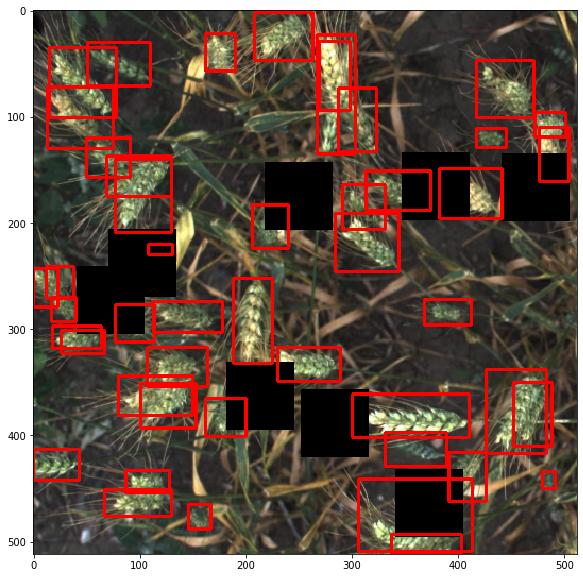

In [100]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(16,10))
for b in box:
    cv2.rectangle(numpy_img,(b[0],b[1]),(b[2],b[3]),(1,0,0),2)
ax.imshow(numpy_img)